In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import LSTM, SimpleRNN, GRU, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Flatten
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [ ]:
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import fbeta_score, make_scorer

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [ ]:
df=pd.read_csv('https://raw.githubusercontent.com/khwanck/DeepMyeSequence/main/dataset/spam.csv',delimiter=',',encoding='latin-1')

In [ ]:
# drop unuse columns
df.rename(columns={'v1':'target','v2':'sms'},inplace=True)
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)
df.dropna()
df.drop_duplicates()
df.head()

,target,sms
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## WordCloud for SMS massage

In [ ]:
df.groupby('target').describe().T
# Get all the ham and spam emails
ham_msg = df[df.target =='ham']
spam_msg = df[df.target=='spam']
# Create numpy list to visualize using wordcloud
ham_msg_text = " ".join(ham_msg.sms.to_numpy().tolist())
spam_msg_text = " ".join(spam_msg.sms.to_numpy().tolist())

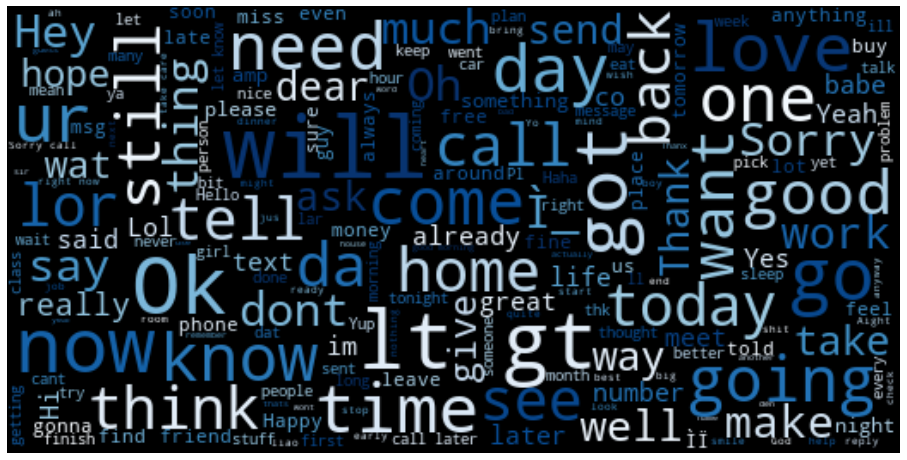

In [ ]:
# wordcloud of ham messages
ham_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Blues').generate(ham_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(ham_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

## LabelEncoding Target Column

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
le=LabelEncoder()

In [ ]:
df['target']=le.fit_transform(df['target'])

## Train_test_split

In [ ]:
x=df['sms']
y=df['target']

In [ ]:
x_train,X_test,y_train,Y_test=train_test_split(x,y,test_size=0.2,random_state=20)
x_test,x_val,y_test,y_val=train_test_split(X_test,Y_test,test_size=0.5,random_state=20)

## Process train dataset

In [ ]:
max_words=1000
max_len=172
token=Tokenizer(num_words=max_words)
token.fit_on_texts(df['sms'])
sequences=token.texts_to_sequences(x_train)
sequences_metrix=sequence.pad_sequences(sequences,padding='post',maxlen=max_len)

In [ ]:
val_sequences = token.texts_to_sequences(x_val)
val_sequences_matrix = sequence.pad_sequences(val_sequences,padding='post',maxlen=max_len)

## Process test dataset

In [ ]:
# process test data
test_sequences = token.texts_to_sequences(x_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,padding='post',maxlen=max_len)

In [ ]:
sequences_metrix.shape,y_train.shape # shape of train dataset

((4457, 172), (4457,))

In [ ]:
val_sequences_matrix.shape,y_val.shape 

((558, 172), (558,))

In [ ]:
test_sequences_matrix.shape,y_test.shape # shape of test dataset

((557, 172), (557,))

In [ ]:
test_sequences_matrix

array([[ 43, 510,  41, ...,   0,   0,   0],
       [477,   5,  43, ...,   0,   0,   0],
       [476,  82,  33, ...,   0,   0,   0],
       ...,
       [  9,   7, 267, ...,   0,   0,   0],
       [ 34, 264,  25, ...,   0,   0,   0],
       [ 27,   3,  70, ...,   0,   0,   0]], dtype=int32)

## Define model RNN

In [ ]:
# SimpleRNN model
model = Sequential()

# embedding layer
model.add(Embedding(max_words,50,input_length=max_len,trainable=True))

# lstm layer
model.add(SimpleRNN(100,return_sequences=True,dropout=0.5))
model.add(Flatten()) 
# Dense layer
model.add(Dense(200,activation='relu',name='hl1')) # hidden layer 1
model.add(Dense(100,activation='relu',name='hl2')) # hidden layer 2
model.add(Dense(1,activation='sigmoid',name='ol')) # output layer
    
# Add loss function, metrics, optimizer
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=["accuracy"])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 172, 50)           50000     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 172, 100)          15100     
                                                                 
 flatten_3 (Flatten)         (None, 17200)             0         
                                                                 
 hl1 (Dense)                 (None, 200)               3440200   
                                                                 
 hl2 (Dense)                 (None, 100)               20100     
                                                                 
 ol (Dense)                  (None, 1)                 101       
                                                                 
Total params: 3,525,501
Trainable params: 3,525,501
No

## Train model RNN

In [ ]:
# Train model
tik = time.time()
history=model.fit( sequences_metrix, y_train, \
                   validation_data=(val_sequences_matrix,y_val), \
                   batch_size=64, epochs=20 )
tok = time.time()
print(tik, tok, tok-tik)

Epoch 1/20
70/70 [==============================] - 10s 124ms/step - loss: 0.2751 - accuracy: 0.9060 - val_loss: 0.0957 - val_accuracy: 0.9749
Epoch 2/20
70/70 [==============================] - 8s 118ms/step - loss: 0.0744 - accuracy: 0.9803 - val_loss: 0.0626 - val_accuracy: 0.9839
Epoch 3/20
70/70 [==============================] - 8s 117ms/step - loss: 0.0460 - accuracy: 0.9874 - val_loss: 0.0705 - val_accuracy: 0.9803
Epoch 4/20
70/70 [==============================] - 8s 117ms/step - loss: 0.0279 - accuracy: 0.9915 - val_loss: 0.0571 - val_accuracy: 0.9839
Epoch 5/20
70/70 [==============================] - 8s 119ms/step - loss: 0.0237 - accuracy: 0.9942 - val_loss: 0.0832 - val_accuracy: 0.9821
Epoch 6/20
70/70 [==============================] - 8s 117ms/step - loss: 0.0192 - accuracy: 0.9944 - val_loss: 0.0701 - val_accuracy: 0.9803
Epoch 7/20
70/70 [==============================] - 8s 116ms/step - loss: 0.0168 - accuracy: 0.9948 - val_loss: 0.1172 - val_accuracy: 0.9803
Epoch

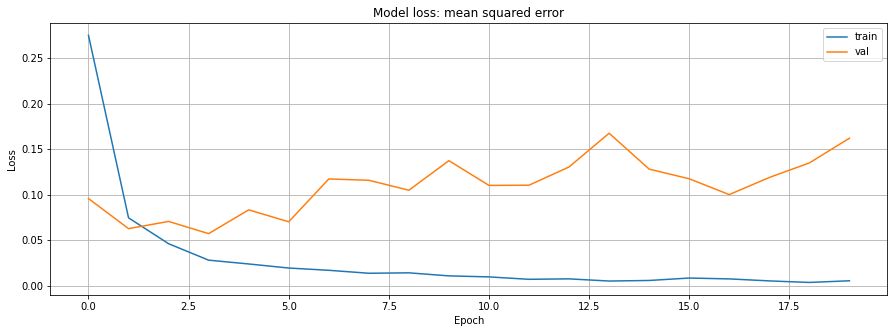

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(15,5)) 
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Model loss: mean squared error') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['train', 'val'], loc='upper right') 
plt.grid()
plt.show()

## Evaluation model RNN

In [ ]:
# evaluation model
train_acc_rnn=model.evaluate(sequences_metrix,y_train,verbose=1) # train dataset evaluate
test_acc_rnn=model.evaluate(test_sequences_matrix,y_test,verbose=1) # test dataset evaluate
time_rnn = tok-tik

18/18 [==============================] - 0s 20ms/step - loss: 0.1417 - accuracy: 0.9838


In [ ]:
print("Loss:{:.3f} and Accuracy:{:.3f}".format(train_acc_rnn[0],train_acc_rnn[1])) # train dataset Loss and Accurancy
print("Loss:{:.3f} and Accuracy:{:.3f}".format(test_acc_rnn[0],test_acc_rnn[1])) # test dataset Loss and Accurancy

Loss:0.002 and Accuracy:1.000
Loss:0.142 and Accuracy:0.984


## Plot training history RNN

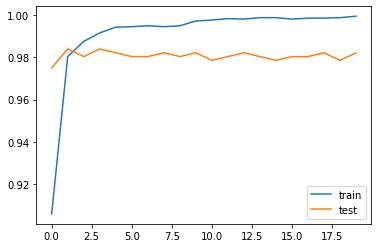

In [ ]:
# plot training history
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

## Define model LSTM

In [ ]:
model=Sequential()

# embedding layer
model.add(Embedding(max_words,50,input_length=max_len,trainable=True))

# lstm layer
model.add(LSTM(100,return_sequences=True,dropout=0.5))
model.add(Flatten()) 
# Dense layer
model.add(Dense(200,activation='relu',name='hl1')) # hidden layer 1
model.add(Dense(100,activation='relu',name='hl2')) # hidden layer 2
model.add(Dense(1,activation='sigmoid',name='ol')) # output layer
    
# Add loss function, metrics, optimizer
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=["accuracy"])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 172, 50)           50000     
                                                                 
 lstm_1 (LSTM)               (None, 172, 100)          60400     
                                                                 
 flatten_4 (Flatten)         (None, 17200)             0         
                                                                 
 hl1 (Dense)                 (None, 200)               3440200   
                                                                 
 hl2 (Dense)                 (None, 100)               20100     
                                                                 
 ol (Dense)                  (None, 1)                 101       
                                                                 
Total params: 3,570,801
Trainable params: 3,570,801
No

## Train model LSTM

In [ ]:
# Train model
tik = time.time()
history=model.fit( sequences_metrix, y_train, \
                   validation_data=(val_sequences_matrix,y_val), \
                   batch_size=64, epochs=20 )
tok = time.time()
print(tik, tok, tok-tik)

Epoch 1/20
70/70 [==============================] - 19s 240ms/step - loss: 0.2586 - accuracy: 0.8968 - val_loss: 0.0840 - val_accuracy: 0.9749
Epoch 2/20
70/70 [==============================] - 16s 233ms/step - loss: 0.0497 - accuracy: 0.9852 - val_loss: 0.0527 - val_accuracy: 0.9875
Epoch 3/20
70/70 [==============================] - 16s 234ms/step - loss: 0.0346 - accuracy: 0.9899 - val_loss: 0.0494 - val_accuracy: 0.9875
Epoch 4/20
70/70 [==============================] - 16s 233ms/step - loss: 0.0251 - accuracy: 0.9924 - val_loss: 0.0777 - val_accuracy: 0.9875
Epoch 5/20
70/70 [==============================] - 17s 236ms/step - loss: 0.0186 - accuracy: 0.9948 - val_loss: 0.0727 - val_accuracy: 0.9875
Epoch 6/20
70/70 [==============================] - 16s 235ms/step - loss: 0.0172 - accuracy: 0.9937 - val_loss: 0.0632 - val_accuracy: 0.9875
Epoch 7/20
70/70 [==============================] - 16s 235ms/step - loss: 0.0143 - accuracy: 0.9955 - val_loss: 0.0634 - val_accuracy: 0.9910

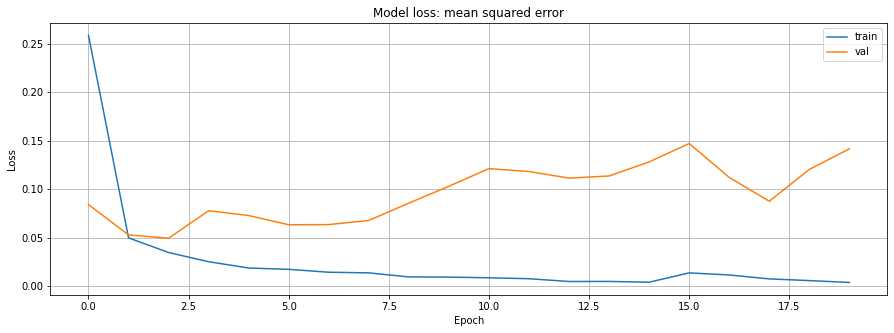

In [ ]:
# Plot training & validation loss values 
plt.figure(figsize=(15,5)) 
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Model loss: mean squared error') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['train', 'val'], loc='upper right') 
plt.grid()
plt.show()

## Evaluation model LSTM

In [ ]:
# evaluation model
train_acc_lstm=model.evaluate(sequences_metrix,y_train,verbose=1) # train dataset evaluate
test_acc_lstm=model.evaluate(test_sequences_matrix,y_test,verbose=1) # test dataset evaluate
time_lstm = tok-tik

18/18 [==============================] - 1s 37ms/step - loss: 0.1037 - accuracy: 0.9910


In [ ]:
print("Loss:{:.3f} and Accuracy:{:.3f}".format(train_acc_lstm[0],train_acc_lstm[1])) # train dataset Loss and Accurancy
print("Loss:{:.3f} and Accuracy:{:.3f}".format(test_acc_lstm[0],test_acc_lstm[1])) # test dataset Loss and Accurancy

Loss:0.002 and Accuracy:1.000
Loss:0.104 and Accuracy:0.991


## Plot training history LSTM

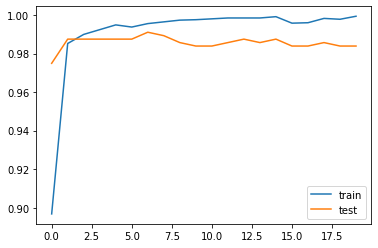

In [ ]:
# plot training history
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

## Define model GRU

In [ ]:
# GRU model
model = Sequential()

# embedding layer
model.add(Embedding(max_words,50,input_length=max_len,trainable=True))

# lstm layer
model.add(GRU(100,return_sequences=True,dropout=0.5))
model.add(Flatten()) 
# Dense layer
model.add(Dense(200,activation='relu',name='hl1')) # hidden layer 1
model.add(Dense(100,activation='relu',name='hl2')) # hidden layer 2
model.add(Dense(1,activation='sigmoid',name='ol')) # output layer
    
# Add loss function, metrics, optimizer
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=["accuracy"])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 172, 50)           50000     
                                                                 
 gru_1 (GRU)                 (None, 172, 100)          45600     
                                                                 
 flatten_5 (Flatten)         (None, 17200)             0         
                                                                 
 hl1 (Dense)                 (None, 200)               3440200   
                                                                 
 hl2 (Dense)                 (None, 100)               20100     
                                                                 
 ol (Dense)                  (None, 1)                 101       
                                                                 
Total params: 3,556,001
Trainable params: 3,556,001
No

## Train model GRU

In [ ]:
# Train model
tik = time.time()
history=model.fit( sequences_metrix, y_train, \
                   validation_data=(val_sequences_matrix,y_val), \
                   batch_size=64, epochs=20 )
tok = time.time()
print(tik, tok, tok-tik)

Epoch 1/20
70/70 [==============================] - 17s 208ms/step - loss: 0.2224 - accuracy: 0.9147 - val_loss: 0.0667 - val_accuracy: 0.9821
Epoch 2/20
70/70 [==============================] - 14s 203ms/step - loss: 0.0536 - accuracy: 0.9854 - val_loss: 0.0528 - val_accuracy: 0.9910
Epoch 3/20
70/70 [==============================] - 14s 205ms/step - loss: 0.0365 - accuracy: 0.9890 - val_loss: 0.0661 - val_accuracy: 0.9821
Epoch 4/20
70/70 [==============================] - 14s 201ms/step - loss: 0.0220 - accuracy: 0.9930 - val_loss: 0.0730 - val_accuracy: 0.9839
Epoch 5/20
70/70 [==============================] - 14s 201ms/step - loss: 0.0227 - accuracy: 0.9924 - val_loss: 0.0528 - val_accuracy: 0.9875
Epoch 6/20
70/70 [==============================] - 14s 203ms/step - loss: 0.0145 - accuracy: 0.9951 - val_loss: 0.0874 - val_accuracy: 0.9875
Epoch 7/20
70/70 [==============================] - 14s 202ms/step - loss: 0.0096 - accuracy: 0.9969 - val_loss: 0.0992 - val_accuracy: 0.9839

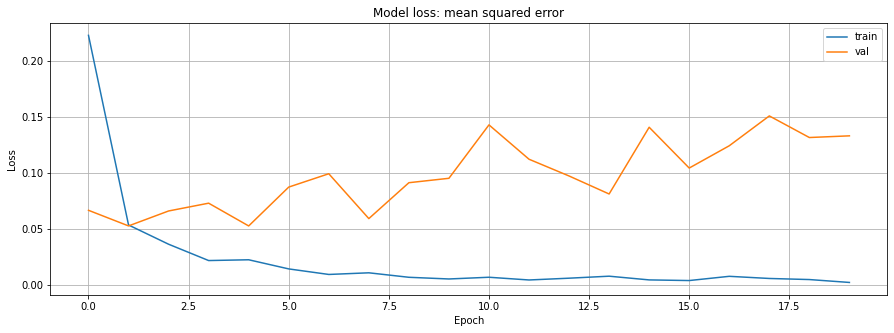

In [ ]:
# Plot training & validation loss values 
plt.figure(figsize=(15,5)) 
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Model loss: mean squared error') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['train', 'val'], loc='upper right') 
plt.grid()
plt.show()

## Evaluation model GRU

In [ ]:
# evaluation model
train_acc_gru=model.evaluate(sequences_metrix,y_train,verbose=1) # train dataset evaluate
test_acc_gru=model.evaluate(test_sequences_matrix,y_test,verbose=1) # test dataset evaluate
time_gru = tok-tik

18/18 [==============================] - 1s 33ms/step - loss: 0.1398 - accuracy: 0.9803


In [ ]:
print("Loss:{:.3f} and Accuracy:{:.3f}".format(train_acc_gru[0],train_acc_gru[1])) # train dataset Loss and Accurancy
print("Loss:{:.3f} and Accuracy:{:.3f}".format(test_acc_gru[0],test_acc_gru[1])) # test dataset Loss and Accurancy

Loss:0.001 and Accuracy:1.000
Loss:0.140 and Accuracy:0.980


## Plot training history GRU

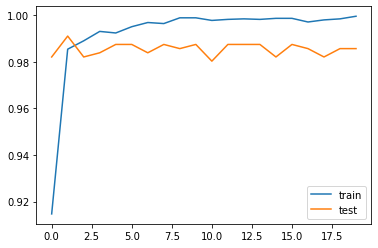

In [ ]:
# plot training history
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

# Traditional ML by NB vs SVM

In [ ]:
# Instantiate the TfidfVectorizer method and fit data
vector = TfidfVectorizer(stop_words = 'english')
training_data = vector.fit_transform(x_train)

# Transform testing data 
testing_data = vector.transform(x_test)
training_data.todense().shape

(4457, 7469)

##Training ML model

In [ ]:
# Instantiate all models
naive_bayes_clf = MultinomialNB()
random_forest_clf = RandomForestClassifier(n_estimators = 200)
svm_clf = SVC()

# Fit models with training data
tik = time.time()
naive_bayes_clf.fit(training_data, y_train)
tok = time.time()
time_nb = tok-tik

tik = time.time()
random_forest_clf.fit(training_data, y_train)
tok = time.time()
time_rf = tok-tik

tik = time.time()
svm_clf.fit(training_data, y_train)
tok = time.time()
time_svm = tok-tik

##Evaluation ML model

In [ ]:
#F-beta score as the evaluation
beta = 0.5
fbeta_scorer = make_scorer(fbeta_score, beta = beta)

def validation_score(model_name):
    scores = cross_val_score(model_name, 
                    training_data, y_train, 
                    cv=10, scoring=fbeta_scorer) 
    rmse= np.sqrt(-cross_val_score(model_name, training_data, y_train, scoring="neg_mean_squared_error", cv = 10))
    return scores, rmse

In [ ]:
nb_val_score = validation_score(naive_bayes_clf)
print(nb_val_score[0], "\n")
print("Average cross-validation F-beta score:", nb_val_score[0].mean())
print(nb_val_score[0], "\n")
print("Average cross-validation RMSE score:", nb_val_score[1].mean())

[0.92672414 0.9375     0.95238095 0.96153846 0.94758065 0.94262295
 0.96153846 0.96525097 0.96590909 0.92105263] 

Average cross-validation F-beta score: 0.9482098297108875
[0.92672414 0.9375     0.95238095 0.96153846 0.94758065 0.94262295
 0.96153846 0.96525097 0.96590909 0.92105263] 

Average cross-validation RMSE score: 0.16755802743156803


In [ ]:
rf_val_score = validation_score(random_forest_clf)
print(rf_val_score[0], "\n")
print("Average cross-validation F-beta score:", rf_val_score[0].mean())
print(rf_val_score[0], "\n")
print("Average cross-validation RMSE score:", rf_val_score[1].mean())

[0.94262295 0.93253968 0.95149254 0.95588235 0.96153846 0.95703125
 0.96153846 0.96078431 0.96153846 0.95149254] 

Average cross-validation F-beta score: 0.9536461009268271
[0.94262295 0.93253968 0.95149254 0.95588235 0.96153846 0.95703125
 0.96153846 0.96078431 0.96153846 0.95149254] 

Average cross-validation RMSE score: 0.1542192423173512


In [ ]:
svm_val_score = validation_score(svm_clf)
print(svm_val_score[0], "\n")
print("Average cross-validation F-beta score:", svm_val_score[0].mean())
print(nb_val_score[0], "\n")
print("Average cross-validation RMSE score:", svm_val_score[1].mean())

[0.91666667 0.93220339 0.94758065 0.96153846 0.94758065 0.91517857
 0.95703125 0.93117409 0.95238095 0.97014925] 

Average cross-validation F-beta score: 0.9431483924967908
[0.92672414 0.9375     0.95238095 0.96153846 0.94758065 0.94262295
 0.96153846 0.96525097 0.96590909 0.92105263] 

Average cross-validation RMSE score: 0.17149466121024717


In [ ]:
def testing_score(model):
    y_pred = model.predict(testing_data)
    fbeta = fbeta_score(y_test, y_pred, beta = beta)
    return round(fbeta, 4)

def print_metrics(models, model_names):
    metrics_dict = {}
    for i in range(len(models)):
        metrics_dict[model_names[i]] = testing_score(models[i])
    return metrics_dict

models = [naive_bayes_clf, random_forest_clf, svm_clf]
model_names = ["Naive Bayes", "Random Forest", "Support Vector Machines"]

print_metrics(models, model_names)

{'Naive Bayes': 0.9509,
 'Random Forest': 0.9807,
 'Support Vector Machines': 0.9807}

# Comparing the evaluation performance of all the models

In [ ]:
lst_eva = [['Loss', test_acc_rnn[0], test_acc_lstm[0], test_acc_gru[0], nb_val_score[1].mean(), rf_val_score[1].mean(), svm_val_score[1].mean()],
           ['Accuracy', test_acc_rnn[1], test_acc_lstm[1], test_acc_gru[1], nb_val_score[0].mean(), rf_val_score[0].mean(), svm_val_score[0].mean()],
           ['Time',time_rnn, time_lstm, time_gru, time_nb, time_rf, time_svm]]

df_eva = pd.DataFrame(lst_eva, columns =['Items', 'RNN', 'LSTM', 'GRU', 'NB', 'RF', 'SVM'])
df_eva

,Items,RNN,LSTM,GRU,NB,RF,SVM
0,Loss,0.141710,0.103748,0.139823,0.167558,0.154219,0.171495
1,Accuracy,0.983842,0.991023,0.980251,0.948210,0.953646,0.943148
2,Time,168.770895,383.873030,323.883921,0.004861,1.969147,1.738394


In [ ]:
fig = make_subplots(rows=1, cols=2, subplot_titles=('Evaluation Loss',  'Evaluation Accuracy'))

fig.add_trace(
    go.Bar(name='Loss', 
           x=['RNN', 'LSTM', 'GRU', 'NB', 'RF', 'SVM'], 
           y=[test_acc_rnn[0], test_acc_lstm[0], test_acc_gru[0], nb_val_score[1].mean(), rf_val_score[1].mean(), svm_val_score[1].mean()]),
           row=1, 
           col=1)

fig.add_trace(
    go.Bar(name='Accuracy', 
           x=['RNN', 'LSTM', 'GRU', 'NB', 'RF', 'SVM'], 
           y=[test_acc_rnn[1], test_acc_lstm[1], test_acc_gru[1], nb_val_score[0].mean(), rf_val_score[0].mean(), svm_val_score[0].mean()]),
           row=1, 
           col=2)

fig.update_layout(title_text='Evaulation Results')
fig.show()

# Comparing the training time for each of the models 

In [ ]:
fig = go.Figure()
fig.add_trace(go.Bar(name='Trianing Time', 
                     x=['RNN', 'LSTM', 'GRU', 'NB', 'RF', 'SVM'], 
                     y=[time_rnn, time_lstm, time_gru, time_nb, time_rf, time_svm]))
fig.update_layout(title_text='Training time of each model')
fig.show()